In [127]:
!pip freeze | grep torch

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
torch==0.4.1
torchvision==0.2.1


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from sklearn.metrics import log_loss
from skopt import gp_minimize

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_j import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [126]:
os.getcwd()

'/home/dsgpucp/Documents/DSG-2018-Finals'

In [125]:
from src.utils_f import duration_feature, watched_category
import lightgbm as lgbm


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')

In [129]:
productid_category = pd.read_csv('data/raw/productid_category.csv')

In [130]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.4)

In [131]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [132]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

In [28]:
proc_train = watched_product(proc_train, trn_tracking, productid_category)
proc_val = watched_product(proc_val, val_tracking, productid_category)
proc_all = watched_product(proc_all, all_tracking, productid_category)
proc_test = watched_product(proc_test, test_tracking, productid_category)

Loading pages


/home/dsgpucp/Documents/DSG-2018-Finals/src/utils_f.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return train_tracking


Loading categories
Loading catmap
Loading pages
Loading categories
Loading catmap
Loading pages
Loading categories
Loading catmap
Loading pages
Loading categories
Loading catmap


In [54]:
proc_train.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,WATCHED_CATEGORY
0,inxo2lfHOeGgN2ySgzK1hAKyCIt17p+honetBOQH4ICtTR...,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.041667,0.083333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,24.0,0.000000,0.166667,0.0,0.041667,0.125,0.0,0.666667,0.000000,24.0,7.840000e-06,11.0
1,4CGnnv6GOcYQp/kxVjcx8nN0u5HgaDaLQkC4xIteZJZ/wK...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875000,0.000000,8.0,0.000000,0.000000,0.0,0.000000,0.125,0.0,0.875000,0.000000,8.0,2.880000e-07,22.0
2,mh22mbOuRnDwAf2OWcrwwymfbZQ/CO3GQuNMO5NREgRV0t...,0.0,0.0,0.000000,0.0,0.0,0.833333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,6.0,0.000000,0.833333,0.0,0.000000,0.000,0.0,0.166667,0.000000,6.0,6.130000e-07,27.0
3,K/+O1PWZ2vASLTrjvBFT7e62Vee1YyOxCrpMJNoL6edmuC...,0.0,0.0,0.181818,0.0,0.0,0.363636,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.090909,11.0,0.181818,0.363636,0.0,0.090909,0.000,0.0,0.272727,0.090909,11.0,2.170000e-07,10.0
4,+8SAgYuptilut4CKRE59ncZFDaF4Y+PX6yJ8g4HaALCxI7...,0.0,0.0,0.000000,0.0,0.0,0.200000,0.6,0.000000,0.000000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.0,0.000000,0.200000,0.6,0.000000,0.200,0.0,0.000000,0.000000,5.0,1.680000e-07,11.0


# Validation

In [89]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [90]:
X_train_noncat = X_train.loc[:, X_train.columns != 'WATCHED_CATEGORY'].copy()
X_val_noncat = X_val.loc[:, X_val.columns != 'WATCHED_CATEGORY'].copy()
X_test_noncat = X_test.loc[:, X_test.columns != 'WATCHED_CATEGORY'].copy()

noncat_columns = X_train_noncat.columns

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_noncat)
X_train_noncat = pd.DataFrame(scaler.transform(X_train_noncat), columns=noncat_columns)
X_val_noncat = pd.DataFrame(scaler.transform(X_val_noncat), columns=noncat_columns)
X_test_noncat = pd.DataFrame(scaler.transform(X_test_noncat), columns=noncat_columns)

In [92]:
X_train_noncat.shape, X_train.shape, X_test_noncat.shape

((79873, 32), (79873, 33), (88750, 32))

In [93]:
# X_train_noncat = pd.merge(X_train_noncat, X_train[['sid', 'WATCHED_CATEGORY']], how='left')
# X_val_noncat = pd.merge(X_val_noncat, X_val[['sid', 'WATCHED_CATEGORY']], how='left')

# X_train = X_train_noncat
# X_val = X_val_noncat

In [94]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10).fit(X_train_noncat)

X_train_pca = (pca.transform(X_train_noncat))
X_val_pca = (pca.transform(X_val_noncat))
X_test_pca = (pca.transform(X_test_noncat))

X_train2 = pd.concat([pd.DataFrame(X_val_noncat), pd.DataFrame(X_train_pca)], axis=1)
X_val2 = pd.concat([pd.DataFrame(X_val_noncat), pd.DataFrame(X_val_pca)], axis=1)
X_test2 = pd.concat([pd.DataFrame(X_test_noncat), pd.DataFrame(X_test_pca)], axis=1)

In [95]:
X_train2.columns = [f'PCA_{x:02}' if str(x).isdigit() else x for x in X_train2.columns]
X_val2.columns = [f'PCA_{x:02}' if str(x).isdigit() else x for x in X_val2.columns]
X_test2.columns = [f'PCA_{x:02}' if str(x).isdigit() else x for x in X_val2.columns]
# X_train.columns

In [96]:
X_train2['WATCHED_CATEGORY'] = X_train.WATCHED_CATEGORY.values
X_val2['WATCHED_CATEGORY'] = X_val.WATCHED_CATEGORY.values
X_test2['WATCHED_CATEGORY'] = X_test.WATCHED_CATEGORY.values

X_train = X_train2
X_val = X_val2
X_test = X_test2

In [97]:
# %%time

# X_train['target'] = y_train
# X_val['target'] = y_val

# X_train.reset_index(drop=True).to_feather('data/processed/trainV1.1.feather')
# X_val.reset_index(drop=True).to_feather('data/processed/valV1.1.feather')
# X_test.reset_index(drop=True).to_feather('data/processed/testV1.1.feather')

In [119]:
# parameters for LightGBMClassifier
params = {
    'max_depth': 30,
    'num_leaves': 40,
    'min_child_samples': 100,
    'scale_pos_weight': 1.0,
    'subsample': 0.9,
    'colsample_bytree': 0.7317081130767846,
    'metric': 'binary_logloss',
    'nthread': 8,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.001,
    'max_bin': 100,
    'lambda_l2': 0.5,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'subsample_freq': 1
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.306822
[200]	valid_0's binary_logloss: 0.300994
[300]	valid_0's binary_logloss: 0.296392
[400]	valid_0's binary_logloss: 0.292763
[500]	valid_0's binary_logloss: 0.289816
[600]	valid_0's binary_logloss: 0.287424
[700]	valid_0's binary_logloss: 0.285456
[800]	valid_0's binary_logloss: 0.283831
[900]	valid_0's binary_logloss: 0.282487
[1000]	valid_0's binary_logloss: 0.281374
[1100]	valid_0's binary_logloss: 0.280455
[1200]	valid_0's binary_logloss: 0.27967
[1300]	valid_0's binary_logloss: 0.279019
[1400]	valid_0's binary_logloss: 0.278463
[1500]	valid_0's binary_logloss: 0.277998
[1600]	valid_0's binary_logloss: 0.277604
[1700]	valid_0's binary_logloss: 0.277277
[1800]	valid_0's binary_logloss: 0.276992
[1900]	valid_0's binary_logloss: 0.276761
[2000]	valid_0's binary_logloss: 0.276564
[2100]	valid_0's binary_logloss: 0.276389
[2200]	valid_0's binary_logloss: 0.276244
[2300]	valid_0's binary_

In [ ]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 8,
    'num_leaves': 21,
    'min_child_samples': 20,
    'scale_pos_weight': 1.0496425512948,
    'subsample': 0.866999534037008,
    'colsample_bytree': 0.5849166790692155,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.03410173379388409,
    'lambda_l2': 0.7395218933709418,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=4017, verbose_eval=100)

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=774, verbose_eval=)

In [17]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [18]:
scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)
X_test = scaler.transform(X_test)

In [19]:
pca = PCA(n_components = 10).fit(X_all)

X_all_pca = pd.DataFrame(pca.transform(X_all))
X_test_pca = pd.DataFrame(pca.transform(X_test))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_pca)], axis=1)

In [20]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=774)

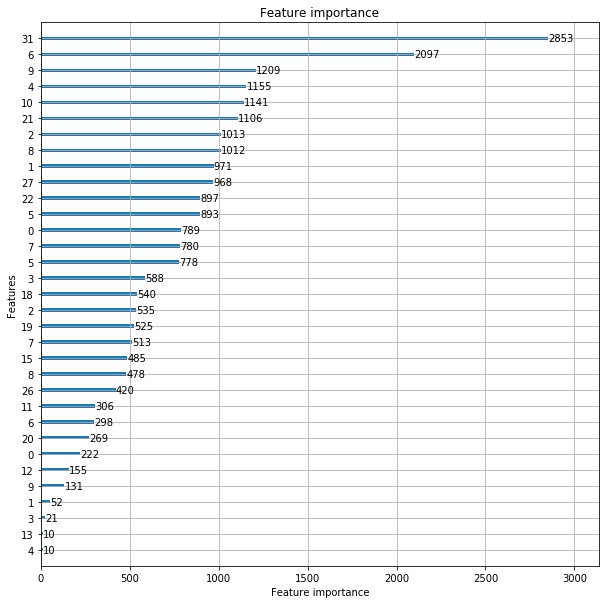

In [21]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [22]:
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_3_submit.csv', index=False)

# Bayesian Tuning 

In [121]:
import warnings
import gc
from sklearn.metrics import log_loss
from skopt import gp_minimize
warnings.filterwarnings("ignore")

In [122]:
space  = [Integer(3, 30, name='max_depth'),
          Integer(6, 40, name='num_leaves'),
          Integer(5, 100, name='min_child_samples'),
          Real(1, 100,  name='scale_pos_weight'),
          Real(0.6, 0.9, name='subsample'),
          Real(0.6, 0.9, name='colsample_bytree'),
          Real(0.0001, 0.1, name='learning_rate'),
          Real(0.001, 10, name='lambda'),
         ]

In [123]:
def objective(values):
    

    params = {'max_depth': values[0], 
              'num_leaves': values[1], 
              'min_child_samples': values[2], 
              'scale_pos_weight': values[3],
              'subsample': values[4],
              'colsample_bytree': values[5],
              'metric':'binary_logloss',
              'nthread': 8,
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'learning_rate': values[6],
              'max_bin': 100,
              'lambda_l2': 0.5,
              'min_child_weight': 0,
              'min_split_gain': 0,
              'subsample_freq': 1}
    

    print('\nNext set of params.....',params)
    
    
    early_stopping_rounds = 30
    num_boost_round       = 100000
    
    d_train = lgbm.Dataset(X_train, label=trn_session.target)
    d_valid = lgbm.Dataset(X_val, label=val_session.target)
        
    evals_results = {}
    model_lgbm    = lgbm.train(params,d_train,valid_sets=[d_valid], 
                               num_boost_round=num_boost_round,
                               early_stopping_rounds=early_stopping_rounds,
                               verbose_eval=None, feval=None)
    
    
    loss = log_loss(y_val, model_lgbm.predict(X_val))
    
    print('\nlog loss.....',loss,".....iter.....", model_lgbm.current_iteration())
    
    gc.collect()
    
    return  loss

In [124]:
res_gp = gp_minimize(objective, space, n_random_starts=10, n_calls=50, random_state=42, verbose=True)
print('Best score=%.4f' % res_gp.fun)

Iteration No: 1 started. Evaluating function at random point.

Next set of params..... {'max_depth': 25, 'num_leaves': 12, 'min_child_samples': 79, 'scale_pos_weight': 60.08816563670222, 'subsample': 0.7337498258560774, 'colsample_bytree': 0.6299924747454009, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.045978964307390145, 'max_bin': 100, 'lambda_l2': 0.5, 'min_child_weight': 0, 'min_split_gain': 0, 'subsample_freq': 1}

log loss..... 0.31630102596500165 .....iter..... 1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5048
Function value obtained: 0.3163
Current minimum: 0.3163
Iteration No: 2 started. Evaluating function at random point.

Next set of params..... {'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 10, 'scale_pos_weight': 72.47787845441566, 'subsample': 0.8815658127047251, 'colsample_bytree': 0.6002336297523043, 'metric': 'binary_logloss', 'nthread': 8, 'boosting_type': 'gbdt', 'ob

KeyboardInterrupt: 

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [41]:
flds = ['max_depth',
        'num_leaves',
        'min_child_samples',
        'scale_pos_weight',
        'subsample',
        'colsample_bytree',
        'learning_rate']

In [42]:
best_params = {i:j for i,j in zip(flds, res_gp.x)}
print('best parameters:')
print(best_params)

best parameters:
{'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 50, 'scale_pos_weight': 1.0, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.01}


In [40]:
res_gp.x

[10, 30, 50, 1.0, 0.9, 0.9, 0.01]

In [44]:
params = {
    'objective' :'binary',
    'max_depth' : 10,
    'num_leaves': 30,
    'min_child_samples': 50,
    'scale_pos_weight': 1.0,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=774)

In [45]:
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/chu_5_submit.csv', index=False)